In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [80]:
import time
import os
from os import listdir
from os.path import isfile, join

import pprint
import random
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageColor, ImageFont
from tqdm.auto import tqdm

import torch
import torchvision
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
plt.rcParams["savefig.bbox"] = 'tight'

plt.style.use('seaborn-white')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
def load_annotation(label_path, image_key):
    with open(join(label_path, '{:s}.json'.format(image_key)), 'r') as fid:
        anno = json.load(fid)
    return anno

In [5]:
data_dir = '/data/shared/mtsd_v2_fully_annotated/'
img_path = join(data_dir, 'train')
label_path = join(data_dir, 'annotations')

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

color = 'red'
alpha = 125
try:
    font = ImageFont.truetype('arial.ttf', 15)
except:
    print('Falling back to default font...')
    font = ImageFont.load_default()

images = []
for i, filename in enumerate(filenames):
    img = Image.open(join(img_path, filename))
#     img = np.array(img)
#     bbox = load_annotation(label_path, filenames.split('.')[0])['objects']['bbox']
#     x1, y1 = bbox['xmin'], bbox['ymin']
#     x2, y2 = bbox['xmax'], bbox['ymax']
    anno = load_annotation(label_path, filename.split('.')[0])
    
    img = img.convert('RGBA')
    img_draw = ImageDraw.Draw(img)

    rects = Image.new('RGBA', img.size)
    rects_draw = ImageDraw.Draw(rects)

    for obj in anno['objects']:
        x1 = obj['bbox']['xmin']
        y1 = obj['bbox']['ymin']
        x2 = obj['bbox']['xmax']
        y2 = obj['bbox']['ymax']

        color_tuple = ImageColor.getrgb(color)
        if len(color_tuple) == 3:
            color_tuple = color_tuple + (alpha,)
        else:
            color_tuple[-1] = alpha

        rects_draw.rectangle((x1+1, y1+1, x2-1, y2-1), fill=color_tuple)
        img_draw.line(((x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)), fill='black', width=1)

        class_name = obj['label']
        img_draw.text((x1 + 5, y1 + 5), class_name, font=font)

    img = Image.alpha_composite(img, rects)
    images.append(img)
    if len(images) == 4:
        break


Falling back to default font...


In [6]:
import pandas as pd 

data = pd.read_csv('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv') 
data

,label,id,shape,width,height
0,warning--added-lane-right--g1,w4-3,diamond,36.0,36.0
1,warning--bicycles-crossing--g2,w11-1,diamond,36.0,36.0
2,warning--bicycles-crossing--g3,NaN,diamond,36.0,36.0
3,warning--bus-stop-ahead--g3,NaN,diamond,36.0,36.0
4,warning--children--g2,NaN,diamond,36.0,36.0
...,...,...,...,...,...
101,regulatory--turn-left--g2,r3-5,rect,30.0,36.0
102,regulatory--turn-right--g3,r3-5,rect,30.0,36.0
103,regulatory--wrong-way--g1,r5-1a,rect,42.0,30.0
104,warning--school-zone--g2,s1-1,pentagon,36.0,36.0


In [7]:
selected_labels = ['octagon,36,36', 'diamond,36,36', 'pentagon,36,36', 'rect,36,48', 'rect,30,36']

grouped_labels = {}
with open('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        for group, selected_label in enumerate(selected_labels):
            if selected_label in line:
                if group in grouped_labels:
                    grouped_labels[group].append(line.split(',')[0])
                else:
                    grouped_labels[group] = [line.split(',')[0]]
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(grouped_labels)

{   0: ['regulatory--stop--g1'],
    1: [   'warning--added-lane-right--g1',
           'warning--bicycles-crossing--g2',
           'warning--bicycles-crossing--g3',
           'warning--bus-stop-ahead--g3',
           'warning--children--g2',
           'warning--crossroads--g3',
           'warning--curve-left--g2',
           'warning--curve-right--g2',
           'warning--dip--g2',
           'warning--divided-highway-ends--g1',
           'warning--divided-highway-ends--g2',
           'warning--domestic-animals--g3',
           'warning--double-curve-first-left--g2',
           'warning--double-curve-first-right--g2',
           'warning--double-turn-first-right--g1',
           'warning--emergency-vehicles--g1',
           'warning--equestrians-crossing--g2',
           'warning--falling-rocks-or-debris-right--g2',
           'warning--falling-rocks-or-debris-right--g4',
           'warning--hairpin-curve-left--g1',
           'warning--height-restriction--g2',
           'war

In [8]:
mtsd_label_to_shape_index = {}
for key in grouped_labels:
    for sign in grouped_labels[key]:
        mtsd_label_to_shape_index[sign] = key
mtsd_label_to_shape_index

{'warning--added-lane-right--g1': 1,
 'warning--bicycles-crossing--g2': 1,
 'warning--bicycles-crossing--g3': 1,
 'warning--bus-stop-ahead--g3': 1,
 'warning--children--g2': 1,
 'warning--crossroads--g3': 1,
 'warning--curve-left--g2': 1,
 'warning--curve-right--g2': 1,
 'warning--dip--g2': 1,
 'warning--divided-highway-ends--g1': 1,
 'warning--divided-highway-ends--g2': 1,
 'warning--domestic-animals--g3': 1,
 'warning--double-curve-first-left--g2': 1,
 'warning--double-curve-first-right--g2': 1,
 'warning--double-turn-first-right--g1': 1,
 'warning--emergency-vehicles--g1': 1,
 'warning--equestrians-crossing--g2': 1,
 'warning--falling-rocks-or-debris-right--g2': 1,
 'warning--falling-rocks-or-debris-right--g4': 1,
 'warning--hairpin-curve-left--g1': 1,
 'warning--height-restriction--g2': 1,
 'warning--horizontal-alignment-left--g1': 1,
 'warning--horizontal-alignment-right--g1': 1,
 'warning--junction-with-a-side-road-acute-left--g1': 1,
 'warning--junction-with-a-side-road-acute-ri

In [9]:
len(selected_labels)

5

In [51]:
# no need to run again since dataset has already been created and saved in /data/shared/...

# for split in ['train', 'val']:
for split in ['val']:
#     qqq
    data_dir = '/data/shared/mtsd_v2_fully_annotated/'
    img_path = join(data_dir, split)
    label_path = join(data_dir, 'annotations')

    image_keys = []
    for entry in os.scandir(img_path):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            image_keys.append(entry.name.split('.jpg')[0])

    for image_key in tqdm(image_keys):
#     for image_key in tqdm(image_keys[13500 + 15800:]):

        anno = load_annotation(label_path, image_key)

        with Image.open(os.path.join(img_path, '{:s}.jpg'.format(image_key))) as img:            
            img = img.convert('RGBA')
        for index, obj in enumerate(anno['objects']):
#             qqq
            class_name = obj['label']

            if class_name not in mtsd_label_to_shape_index:
                # (k+1)th label
                shape_index = len(selected_labels)
#                 continue
            else:
                shape_index = mtsd_label_to_shape_index[class_name]
                    
            x1 = obj['bbox']['xmin']
            y1 = obj['bbox']['ymin']
            x2 = obj['bbox']['xmax']
            y2 = obj['bbox']['ymax']
            
            box_length = 1.1 * max((x2 - x1, y2 - y1))
            width_change = box_length - (x2 - x1)
            height_change = box_length - (y2 - y1)

            x1 = x1 - width_change/2
            x2 = x2 + width_change/2

            y1 = y1 - height_change/2
            y2 = y2 + height_change/2
            
#             print((x2 - x1, y2 - y1))
            img_cropped = img.crop((x1, y1, x2, y2))
            
            img_cropped_resized = img_cropped.resize((64, 64))
            
            save_dir = '/data/shared/mtsd_v2_fully_annotated/'
            save_dir = join(save_dir, '{}_cropped_signs'.format(split))

            save_dir = join(save_dir, str(shape_index))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            image_name = '{}_{}'.format(image_key, index)
            save_dir = join(save_dir, image_name + '.jpg')

            img_cropped_resized = img_cropped_resized.convert('RGB')
            qqq
            img_cropped_resized = img_cropped_resized.save(save_dir)


  0%|          | 0/5320 [00:00<?, ?it/s]

NameError: name 'qqq' is not defined

In [10]:
train_label_count = {}
directory = '/data/shared/mtsd_v2_fully_annotated/train_cropped_signs'

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    train_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            train_label_count[shape_index] += 1
train_label_count

{0: 1212, 1: 7191, 2: 226, 3: 833, 4: 743, 5: 170081}

In [11]:
# about 94% of training data is 'other' class
np.array(list(train_label_count.values()))/sum(np.array(list(train_label_count.values())))

array([0.00672265, 0.03988662, 0.00125356, 0.00462044, 0.00412123,
       0.94339549])

In [67]:
# about 80% of training data is 'other' class
np.array(list(train_label_count.values()))/sum(np.array(list(train_label_count.values())))

array([0.02377696, 0.13828478, 0.00451375, 0.0172571 , 0.01194547,
       0.80422195])

In [68]:
directory = '/data/shared/mtsd_v2_fully_annotated/train_cropped_signs_undersample'
other_class_directory = join(directory, '5')
image_keys = []
for entry in os.scandir(other_class_directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        image_keys.append(entry.name.split('.jpg')[0])
kept_images = np.random.choice(image_keys, size=int(len(image_keys) * 0.3), replace=False)
print(len(kept_images))

for entry in os.scandir(other_class_directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        if entry.name.split('.jpg')[0] not in kept_images:
            os.remove(join(other_class_directory, entry.name))

train_label_count = {}

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    train_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            train_label_count[shape_index] += 1
print(train_label_count)

# about 55% of training data is 'other' class
np.array(list(train_label_count.values()))/sum(np.array(list(train_label_count.values())))

10583

In [12]:
val_label_count = {}
directory = '/data/shared/mtsd_v2_fully_annotated/val_cropped_signs'

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    val_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            val_label_count[shape_index] += 1
val_label_count

{0: 321, 1: 1896, 2: 54, 3: 228, 4: 196, 5: 29771}

In [13]:
# about 90% of validation data is 'other' class
np.array(list(val_label_count.values()))/sum(np.array(list(val_label_count.values())))

array([0.00988727, 0.05839956, 0.00166328, 0.00702273, 0.00603708,
       0.91699008])

In [11]:
BATCH_SIZE = 256

In [12]:
# getting mean and std of each channel
train_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/train_cropped_signs/', transform=torchvision.transforms.ToTensor())
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

mean = 0.
std = 0.
for images, _ in train_data_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_data_loader.dataset)
std /= len(train_data_loader.dataset)

print('mean', mean)
print('std', std)

mean tensor([0.3891, 0.3978, 0.3728])
std tensor([0.1688, 0.1622, 0.1601])


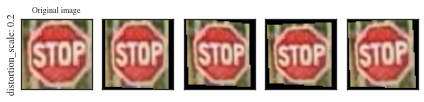

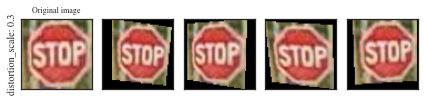

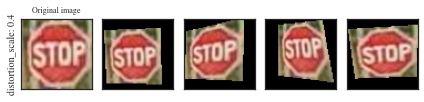

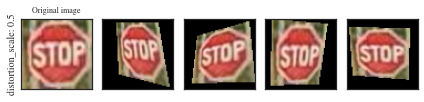

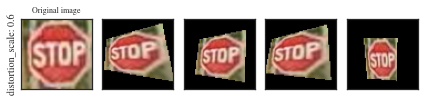

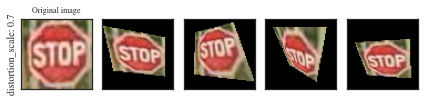

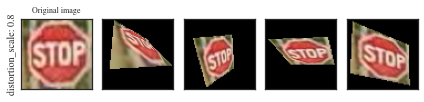

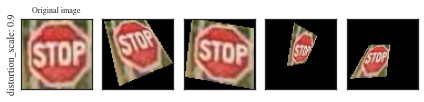

In [35]:
# code to visualize transform
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [img_cropped_resized] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title)

    plt.tight_layout()
    
for scale in np.arange(0.2, 1, 0.1):
    perspective_transformer = torchvision.transforms.RandomPerspective(distortion_scale=scale, p=1.0)
    perspective_imgs = [perspective_transformer(img_cropped_resized) for _ in range(4)]

    plot(perspective_imgs, row_title='distortion_scale: {}'.format(round(scale, 1)))

### Dataloaders

In [13]:
TRANSFORM_IMG = torchvision.transforms.Compose([
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
    torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    torchvision.transforms.ToTensor()
])

TRANSFORM_IMG_VALIDATION = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [14]:
train_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/train_cropped_signs/', transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [15]:
val_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/val_cropped_signs/', transform=TRANSFORM_IMG_VALIDATION)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

## Model Training

In [16]:
import torch.nn as nn
import torchvision.models as models

In [17]:
class Normalize(nn.Module):
    def __init__(self, mean, sd, *args, **kwargs):
        super().__init__()
        self.register_buffer('mean', torch.tensor(mean)[None, :, None, None])
        self.register_buffer('sd', torch.tensor(sd)[None, :, None, None])

    def forward(self, x):
        return (x - self.mean) / self.sd

In [18]:
normalization_net = Normalize(mean, std)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 6)

model_path = '/home/nab_126/adv-patch-bench/model_weights/resnet18.pth'
if os.path.exists(model_path):
    print('loading model weights')
    model.load_state_dict(torch.load(model_path))

/home/nab_126/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/nab_126/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


loading model weights


In [19]:
if torch.cuda.is_available():
    normalization_net = normalization_net.cuda()
    model = model.cuda()

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
save_mode = True

In [31]:
epochs = 1000
min_valid_loss = np.inf

normalization_net.eval()

for e in range(epochs):
    train_loss = 0.0
    correct_train = 0
    model.train()
    for data, labels in train_data_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        optimizer.zero_grad()
        
        data = normalization_net(data)
        logits = model(data)
        
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).float().sum()

        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
     
    valid_loss = 0.0
    correct_val = 0
    model.eval()
    for data, labels in val_data_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        data = normalization_net(data)
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        correct_val += (preds == labels).float().sum()
        
        loss = criterion(logits, labels)
        valid_loss += loss.item()
     
    print('Epoch: {}'.format(e))
    
    train_accuracy = 100 * correct_train / len(train_data)
    val_accuracy = 100 * correct_val / len(val_data)

    print('Training Accuracy: {}'.format(train_accuracy))
    print('Validation Accuracy: {}'.format(val_accuracy))
    print()
    if min_valid_loss > valid_loss and save_mode:
        min_valid_loss = valid_loss
         
        # Saving State Dict
        model_path = '/home/nab_126/adv-patch-bench/model_weights/resnet18_2.pth'

        torch.save(model.state_dict(), model_path)

Epoch: 0
Training Accuracy: 97.43352508544922
Validation Accuracy: 96.78740692138672

Epoch: 1
Training Accuracy: 97.4496078491211
Validation Accuracy: 96.65496063232422

Epoch: 2
Training Accuracy: 97.44628143310547
Validation Accuracy: 96.06973266601562

Epoch: 3
Training Accuracy: 97.50452423095703
Validation Accuracy: 96.9937744140625

Epoch: 4
Training Accuracy: 97.42298889160156
Validation Accuracy: 96.63031768798828

Epoch: 5
Training Accuracy: 97.51451110839844
Validation Accuracy: 96.9537353515625

Epoch: 6
Training Accuracy: 97.5073013305664
Validation Accuracy: 96.72272491455078

Epoch: 7
Training Accuracy: 97.51783752441406
Validation Accuracy: 97.01841735839844

Epoch: 8
Training Accuracy: 97.54501342773438
Validation Accuracy: 97.06770324707031

Epoch: 9
Training Accuracy: 97.5073013305664
Validation Accuracy: 96.94757080078125

Epoch: 10
Training Accuracy: 97.46292114257812
Validation Accuracy: 97.12006378173828

Epoch: 11
Training Accuracy: 97.554443359375
Validation Ac

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/nab_126/anaconda3/envs/env/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/nab_126/anaconda3/envs/env/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/nab_126/anaconda3/envs/env/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/nab_126/anaconda3/envs/env/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## Checking misclassifications

In [23]:
normalization_net = Normalize(mean, std)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 6)

model_path = '/home/nab_126/adv-patch-bench/model_weights/resnet18_2.pth'
if os.path.exists(model_path):
    print('loading model weights')
    model.load_state_dict(torch.load(model_path))
    
val_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/val_cropped_signs/', transform=TRANSFORM_IMG_VALIDATION)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

loading model weights


In [24]:
if torch.cuda.is_available():
    normalization_net = normalization_net.cuda()
    model = model.cuda()

In [83]:
model.eval()
correct_val = 0

mislabelled_dict = np.zeros((len(selected_labels)+1, len(selected_labels)+1))

mislabelled_data = []

for data, labels in val_data_loader:
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
    data_normalized = normalization_net(data)
    logits = model(data_normalized)
    preds = torch.argmax(logits, dim=1)
    
    if (preds != labels).item():
        mislabelled_dict[labels.item()][preds.item()] += 1
        
        mislabelled_data.append([data, labels.item(), preds.item()])
    correct_val += (preds == labels).float().sum()

val_accuracy = 100 * correct_val / len(val_data)
print('Validation Accuracy: {}'.format(val_accuracy))

Validation Accuracy: 97.12006378173828


In [89]:
# row index is real label
# column index is prediction
mislabelled_dict

array([[  0.,   0.,   0.,   0.,   0.,  48.],
       [  0.,   0.,   0.,   0.,   0., 261.],
       [  0.,   0.,   0.,   0.,   0.,   8.],
       [  0.,   0.,   0.,   0.,   0.,  44.],
       [  0.,   0.,   0.,   0.,   0.,  48.],
       [ 30., 453.,  12.,  21.,  10.,   0.]])

In [91]:
selected_labels.append('other')

In [92]:
selected_labels

['octagon,36,36',
 'diamond,36,36',
 'pentagon,36,36',
 'rect,36,48',
 'rect,30,36',
 'other']

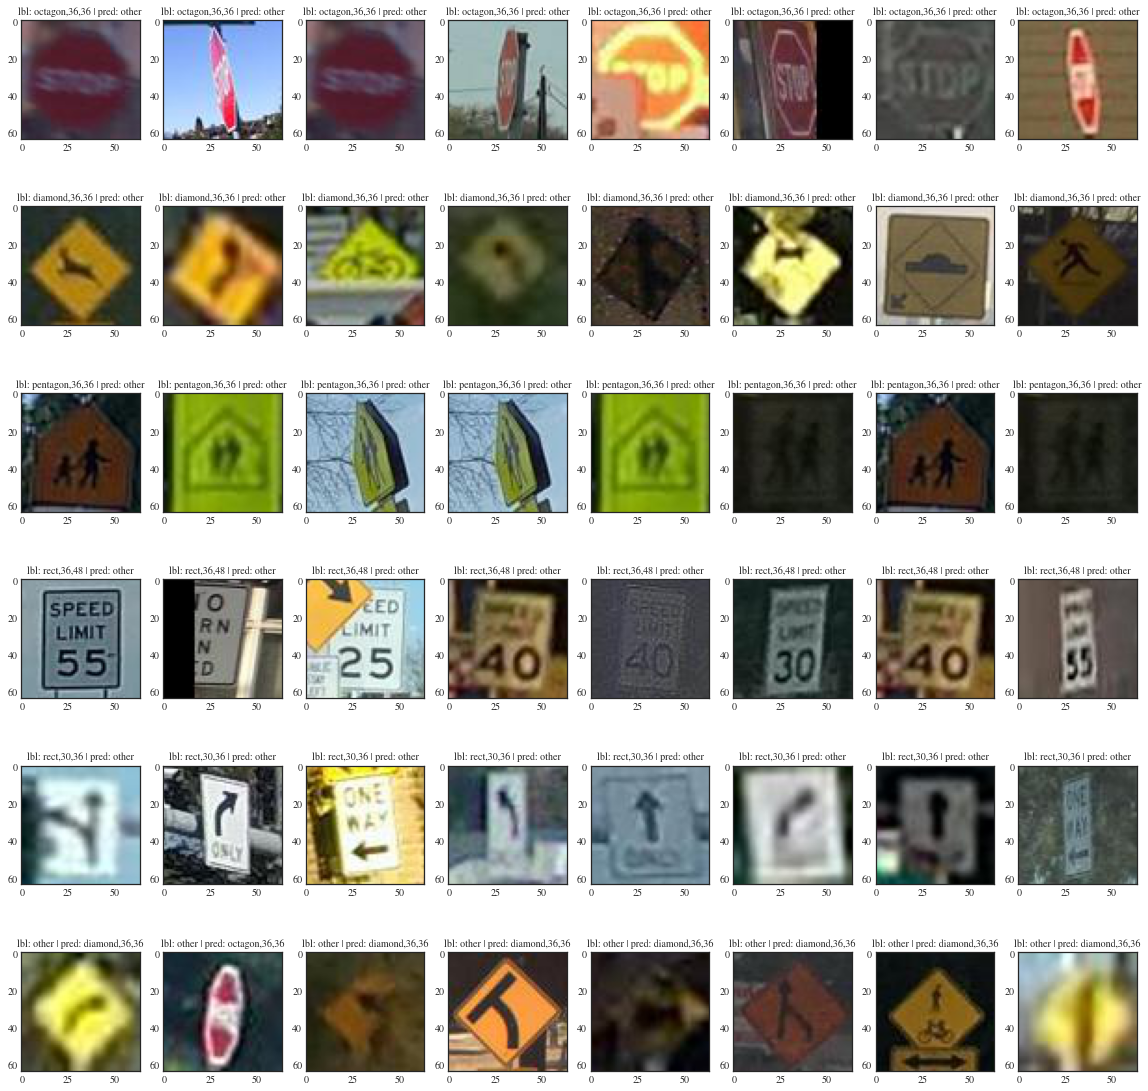

In [95]:
num_plots_per_label = 8
fig, ax = plt.subplots(6, num_plots_per_label)
fig.set_figheight(20)
fig.set_figwidth(20)
counts = [0] * 6

random.shuffle(mislabelled_data)
for i in range(len(mislabelled_data)):
    label = mislabelled_data[i][1]
    prediction = mislabelled_data[i][2]
    if counts[label] == num_plots_per_label:
        continue
    img = mislabelled_data[i][0].cpu()[0]
    img = img.permute(1, 2, 0)
    ax[label][counts[label]].set_title('lbl: {} | pred: {}'.format(selected_labels[label], selected_labels[prediction]), fontsize=10)
    ax[label][counts[label]].imshow(img)
    
    counts[label] += 1


## Applying model to BDD100K dataset

In [33]:
data_dir = '/home/chawin/data/bdd100k/'
data_dir = '/data/shared/bdd100k/'
img_path = join(data_dir, 'images/10k/train/')
label_path = join(data_dir, 'labels/sem_seg/masks/train/')
label = 7       # Set to class of the object to show

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

images = []
for i, filename in enumerate(filenames):
    img = read_image(join(img_path, filename))
    mask = read_image(join(label_path, filename.split('.')[0] + '.png', ))
    if (mask == label).any():
        img = draw_segmentation_masks(img, masks=mask == label, alpha=.6, colors=(60, 255, 0))
        images.append(img)
        print(f'Number of object pixels: {(mask == label).int().sum().item():d}')
    if len(images) == 8:
        break

FileNotFoundError: [Errno 2] No such file or directory: '/data/shared/bdd100k/images/10k/train/'